# Gaussian Mixture Model

[Using Scikit-learn](./using-scikit-learn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets.samples_generator import make_blobs

k = 2
(X_train, y_train) = make_blobs(n_samples=200, n_features=2, centers=k, cluster_std=1.2, random_state=50)

plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_train)
plt.show()

<Figure size 640x480 with 1 Axes>

## Using Scikit-learn

Centroids:
 [-0.14258616 -5.53867115]
[-4.93210034 -2.13480973]
Variances:
 [[ 1.71348867 -0.12599404]
 [-0.12599404  1.57538432]]
[[1.17465728 0.2128774 ]
 [0.2128774  1.20023087]]
Weights::
 0.5096731147900055
0.4903268852099945


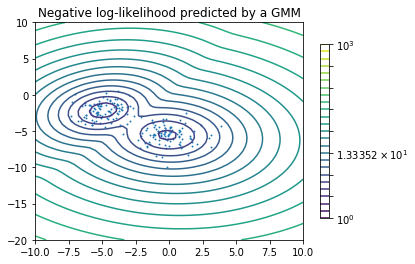

In [2]:
from matplotlib.colors import LogNorm
from sklearn import mixture

clf = mixture.GaussianMixture(n_components=k, covariance_type='full')
clf.fit(X_train)

print("Centroids:\n", "\n".join(map(str, clf.means_)))
print("Variances:\n", "\n".join(map(str, clf.covariances_)))
print("Weights::\n", "\n".join(map(str, clf.weights_)))

# display predicted scores by the model as a contour plot
x = np.linspace(-10., 10.)
y = np.linspace(-20., 10.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 25))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()


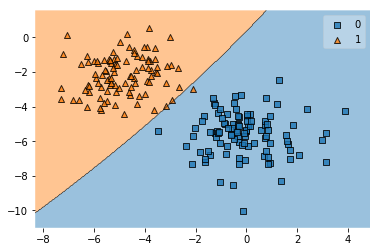

In [5]:
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(X_train, y_train, clf=clf)

## Naive Implementation


In [10]:
import scipy.stats

def fit(X, k):
    M, N = X.shape
    centroids_idx = np.random.choice(np.arange(X.shape[0]), k, replace=False)
    centroids = X[centroids_idx]
    
    mean_x = np.mean(X, axis=0)
    # assume variance is the same for every direction - take the average...
    variances = np.repeat(np.mean(np.sum(np.square(X - mean_x), axis=0) / (X.shape[0] - 1)), k)
    priors = np.repeat(1/k, k)
    
    old_probabilities = None
    new_probabilities = np.zeros((X.shape[0], k))
    
    max_iterations = 50
    it = 0
    
    while (old_probabilities != new_probabilities).any() and it < max_iterations:
        old_probabilities = np.copy(new_probabilities)
        
        # expectation step
        for i, x in enumerate(X):
            normal_distributions = [scipy.stats.multivariate_normal(c, np.eye(N)*v) for c, v in zip(centroids, variances)]
            soft_assignments_probabilities = [nd.pdf(x)*prior for nd, prior in zip(normal_distributions, priors)]
            soft_assignments_probabilities = np.array(soft_assignments_probabilities)
            soft_assignments_probabilities = soft_assignments_probabilities / np.sum(soft_assignments_probabilities)
            
            new_probabilities[i] = soft_assignments_probabilities
        
        # maximization step
        for c in range(k):
            priors[c] = np.mean(new_probabilities[:, c], axis=0)
            sum_probabilities_k = np.sum(new_probabilities[:, c])
            centroids[c] = np.sum(X * new_probabilities[:, c].reshape(-1, 1), axis=0) / sum_probabilities_k
            variances[c] = np.mean(np.sum(np.square(X - centroids[c]) * new_probabilities[:, c].reshape(-1, 1), axis=0) / sum_probabilities_k) 
            
        it += 1
    
    print("Done! #iterations: ", it)
    model = {"centroids": centroids, "variances": variances, "weights": priors}
    return model


def predict(model, X):
    N = X.shape[1]
    centroids, variances, weights = model["centroids"], model["variances"], model["weights"]
    normal_distributions = [scipy.stats.multivariate_normal(c, np.eye(N)*v) for c, v in zip(centroids, variances)]
    soft_assignments_probabilities = [nd.pdf(X)*prior for nd, prior in zip(normal_distributions, weights)]
    soft_assignments_probabilities = np.array(soft_assignments_probabilities).T
    soft_assignments_probabilities = soft_assignments_probabilities / np.sum(soft_assignments_probabilities, axis=1)[:, np.newaxis]
    return np.argmax(soft_assignments_probabilities, axis=1)
    


Done! #iterations:  32
(200,)
[0 1 1 0 1]
Centroids:
 [-0.11496036 -5.55622581]
[-4.91174423 -2.15139444]
Variances:
 1.601261870228529
1.2143001542158323
Weights:
 0.5046569886626208
0.4953430113373793


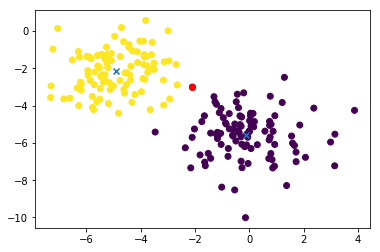

In [11]:
model = fit(X_train, k)
centroids, variances, weights = model["centroids"], model["variances"], model["weights"]

# y_pred = np.array([np.argmin(np.linalg.norm(centroids - x, axis=1)) for x in X])
y_pred = predict(model, X_train)
print(y_pred.shape)
print(y_pred[:5])

print("Centroids:\n", "\n".join(map(str, centroids)))
print("Variances:\n", "\n".join(map(str, variances)))
print("Weights:\n", "\n".join(map(str, weights)))

plt.scatter(X_train[:, 0], X_train[:, 1], marker='o', c=y_pred)
plt.scatter(centroids[:, 0], centroids[:, 1, ], marker='x')


# plot misclassified points - makes sense only if k_true = k_fit
misclassified_points = X_train[y_train != y_pred]
plt.scatter(misclassified_points[:, 0], misclassified_points[:, 1], c='r')

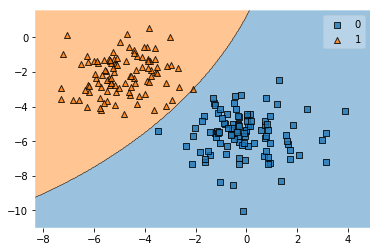

In [12]:
from mlxtend.plotting import plot_decision_regions


class Wrapper():
    def predict(self, X):
        y = predict(model, X)
        return y

plot_decision_regions(X_train, y_train, clf=Wrapper())